## Jordan's RNN
## Pablo Valdunciel Sánchez 
## 15th December, 2019

# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data preparation

In [5]:
def split_sequence(sequence, n_steps):
    X = []
    Y = []
    num_records = len(sequence) - n_steps

    for i in range(num_records):
        X.append(sequence[i:i+n_steps])
        Y.append(sequence[i+n_steps])
        
    return np.array(X),np.array(Y)

In [6]:
SEQ_LEN = 20 
HOLD_OUT = 0.66
X_MAX = 15 

# Read file containing the stock values 
data = pd.read_excel('./data/historica Iberdrola DIC 16-19.xls', dtype={'Fecha': str, 'Último': float}).values 

# Reverse the data set so that most ancient values go first 
data = np.flip(data, axis=0)

# Separate dates and stock_vales
dates = data[:,0]
stock_values = data[:,1]

# Split the sequence
X,Y = split_sequence(stock_values, SEQ_LEN)

# Scale the stock_values 
X = X / X_MAX 
Y = Y / X_MAX 

# Get train and test sets (Holdout)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-HOLD_OUT), random_state=2) 

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(475, 20) (245, 20) (475,) (245,)


# Jordan RNN class
 

In [7]:
# -----------------------------------------------------------------------------
# Jordan recurrent network
# Copyright (C) 2011  Nicolas P. Rougier
#
# Distributed under the terms of the BSD License.
# -----------------------------------------------------------------------------
# This is an implementation of the multi-layer perceptron with retropropagation
# learning.
# -----------------------------------------------------------------------------

class JordanRNN:
    """ Jordan network class"""

    def __init__(self, layer_sizes, alpha=0.1, momentum=0.1, max_iteration=100, verbose=False):
        """ Initialize Jordan RNN """

        self.layer_sizes = layer_sizes
        self.alpha = alpha 
        self.momentum = momentum 
        self.max_iteration = max_iteration
        self.__N = [] # Layers
        self.__W = [] # Weights  
        self.__verbose = verbose 

        self.__build_layers()        
        print(self)


    @staticmethod
    def sigmoid(x):
        """Sigmoid like function using tan"""
        return np.tanh(x)

    @staticmethod
    def dsigmoid(x):
        """ Derivative of sigmoid function """
        return 1.0-x**2

    @property
    def n_layers(self):
        return len(self.layer_sizes)

    def __str__(self):
        """Obtain a string representation of the object."""
        return "JordanRNN(layer_sizes={}, alpha={}, momentum={}, max_iteration={}, verbose={})\n".format(
                                self.layer_sizes, self.alpha, self.momentum, self.max_iteration, self.__verbose)
        
    def __build_layers(self): 
        """Build the network layers """

        # Input layer
        self.__N.append(np.ones(self.layer_sizes[0]+1+self.layer_sizes[-1]))

        # Hidden layer(s) + output layer
        for i in range(1, self.n_layers):
            self.__N.append(np.ones(self.layer_sizes[i]))

        # Build and fill weights matrix       
        for i in range(self.n_layers-1):
            self.__W.append(np.zeros((self.__N[i].size,
                                          self.__N[i+1].size)))
        self.__reset_weights()

        # Last change in weights (for momentum)
        self.__delta_w = [0,]*len(self.__W)        


    def __reset_weights(self):
        """ Reset the weights matrix """

        for i in range(len(self.__W)):
            r = np.random.random((self.__N[i].size, self.__N[i+1].size))
            self.__W[i][...] = (2*r-1)*0.25

    
    def __forward_propagation(self, inputs):
        """ Propagate data from input layer to output layer """
        
        # Set input vector of the network
        self.__N[0][:self.layer_sizes[0]] = inputs  # Data inputs  
        self.__N[0][self.layer_sizes[0]:-1] = self.__N[-1] # Recurrent connections

        # Progate forward
        for i in range(1, len(self.layer_sizes)):
            self.__N[i][...] = JordanRNN.sigmoid(np.dot(self.__N[i-1], self.__W[i-1]))

        # Return output
        return self.__N[-1]


    def __backward_propagation(self, target):
        """ Back propagate error related to target using alpha """
          
        deltas = []
        # Compute error on output layer       
        err = target - self.__N[-1]
        delta = err * JordanRNN.dsigmoid(self.__N[-1])
        deltas.append(delta)

        # Compute error on hidden layers
        for i in range(len(self.layer_sizes)-2,0,-1):
            delta = np.dot(deltas[0], self.__W[i].T) * JordanRNN.dsigmoid(self.__N[i])
            deltas.insert(0,delta)
            
        # Update weights
        for i in range(len(self.__W)):
            layer = np.atleast_2d(self.__N[i])
            delta = np.atleast_2d(deltas[i])
            delta_w = np.dot(layer.T, delta)
            self.__W[i] += self.alpha*delta_w + self.momentum*self.__delta_w[i]
            self.__delta_w[i] = delta_w

        loss = (err**2).sum()

        return loss
    
    def fit(self, inputs, targets):
        """Fit the Jordan network with the given inputs and targets"""
        
        num_samples = inputs.shape[0]        
        self.__reset_weights()
        
        for epoch in range(self.max_iteration):            
            for i in range(num_samples):                
                self.__forward_propagation(inputs[i])
                loss = self.__backward_propagation(targets[i])  
            if self.__verbose:
                print("- Epoch {}, loss = {}".format(epoch, loss))   
    

    def predict(self, inputs):
        """Predict the output for the given inputs"""
        
        num_samples = inputs.shape[0]
        outputs = np.zeros([num_samples])
        
        for i in range(num_samples):
            outputs[i] = self.__forward_propagation(inputs[i])
        
        return outputs
    
    def evaluate(self, inputs, targets, margin=0.02):
        """Compute accuracy of the predictions for the given inputs"""
        predictions = self.predict(inputs)
        hits = 0
        for i in range(len(predictions)):
            rel_error = abs( (predictions[i]/targets[i]) - 1 )
            if rel_error <= margin:
                hits += 1

        return hits/len(predictions)
        

# Class testing

In [8]:
MAX_ITERATION = 150
MARGIN = 0.03

### Create and fit network

In [9]:
jordan = JordanRNN(layer_sizes=[SEQ_LEN,7,1], max_iteration=MAX_ITERATION, verbose=True)
jordan.fit(x_train, y_train)

JordanRNN(layer_sizes=[20, 7, 1], alpha=0.1, momentum=0.1, max_iteration=150, verbose=True)

- Epoch 0, loss = 4.186532709598296e-05
- Epoch 1, loss = 2.0333245289650218e-05
- Epoch 2, loss = 1.1840476772995773e-05
- Epoch 3, loss = 8.721086786678967e-06
- Epoch 4, loss = 7.647421171874972e-06
- Epoch 5, loss = 7.357319394489025e-06
- Epoch 6, loss = 7.362978558576694e-06
- Epoch 7, loss = 7.465864062629643e-06
- Epoch 8, loss = 7.583451353718735e-06
- Epoch 9, loss = 7.682472320960043e-06
- Epoch 10, loss = 7.751115014417926e-06
- Epoch 11, loss = 7.786893243556725e-06
- Epoch 12, loss = 7.791237777975183e-06
- Epoch 13, loss = 7.767070947513132e-06
- Epoch 14, loss = 7.717727717994072e-06
- Epoch 15, loss = 7.646489018721241e-06
- Epoch 16, loss = 7.556393854391036e-06
- Epoch 17, loss = 7.450177669371751e-06
- Epoch 18, loss = 7.33026688290363e-06
- Epoch 19, loss = 7.198797308364701e-06
- Epoch 20, loss = 7.057641574696401e-06
- Epoch 21, loss = 6.908438720312429e-06
- Epoch 22, lo

### Predict

In [10]:
predictions = jordan.predict(x_test)
hit_rate = jordan.evaluate(x_test, y_test, margin=MARGIN)

print("Hit rate (relative error <= {}) = {}".format(MARGIN, hit_rate ))

Hit rate (relative error <= 0.03) = 0.8


### Comparison

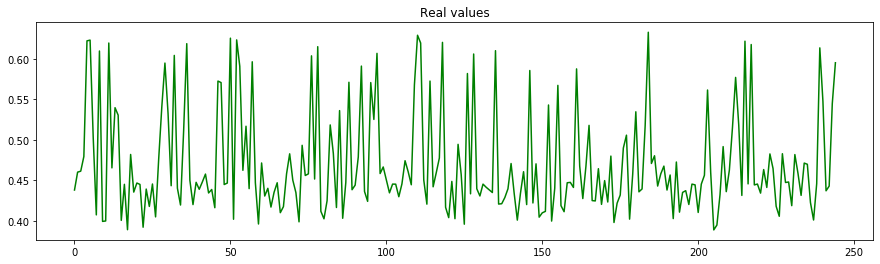

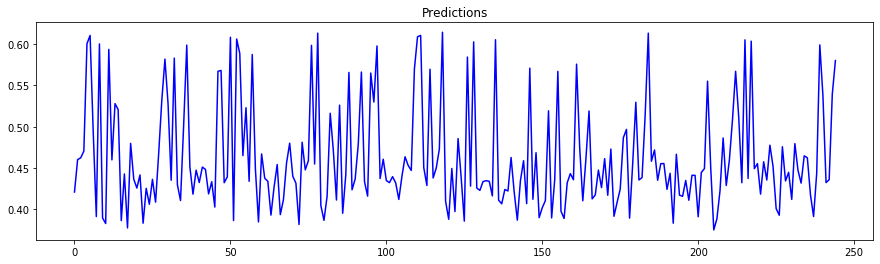

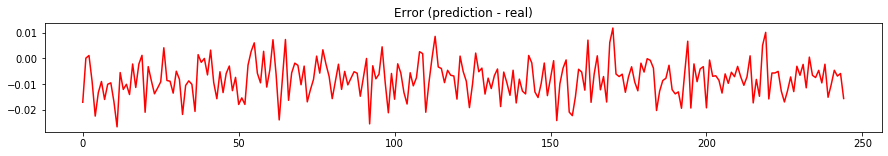

In [11]:
fig = plt.figure(figsize=(15,4))
x = range(len(predictions))
plt.plot(x, y_test, 'green')
plt.title("Real values")
plt.show()

fig = plt.figure(figsize=(15,4))
plt.plot(x, predictions, 'blue')
plt.title("Predictions")
plt.show()

fig = plt.figure(figsize=(15,2))
plt.plot(x, predictions-y_test, 'red')
plt.title("Error (prediction - real)")
plt.show()